# Predicting House Sale Prices (using Linear Regression)

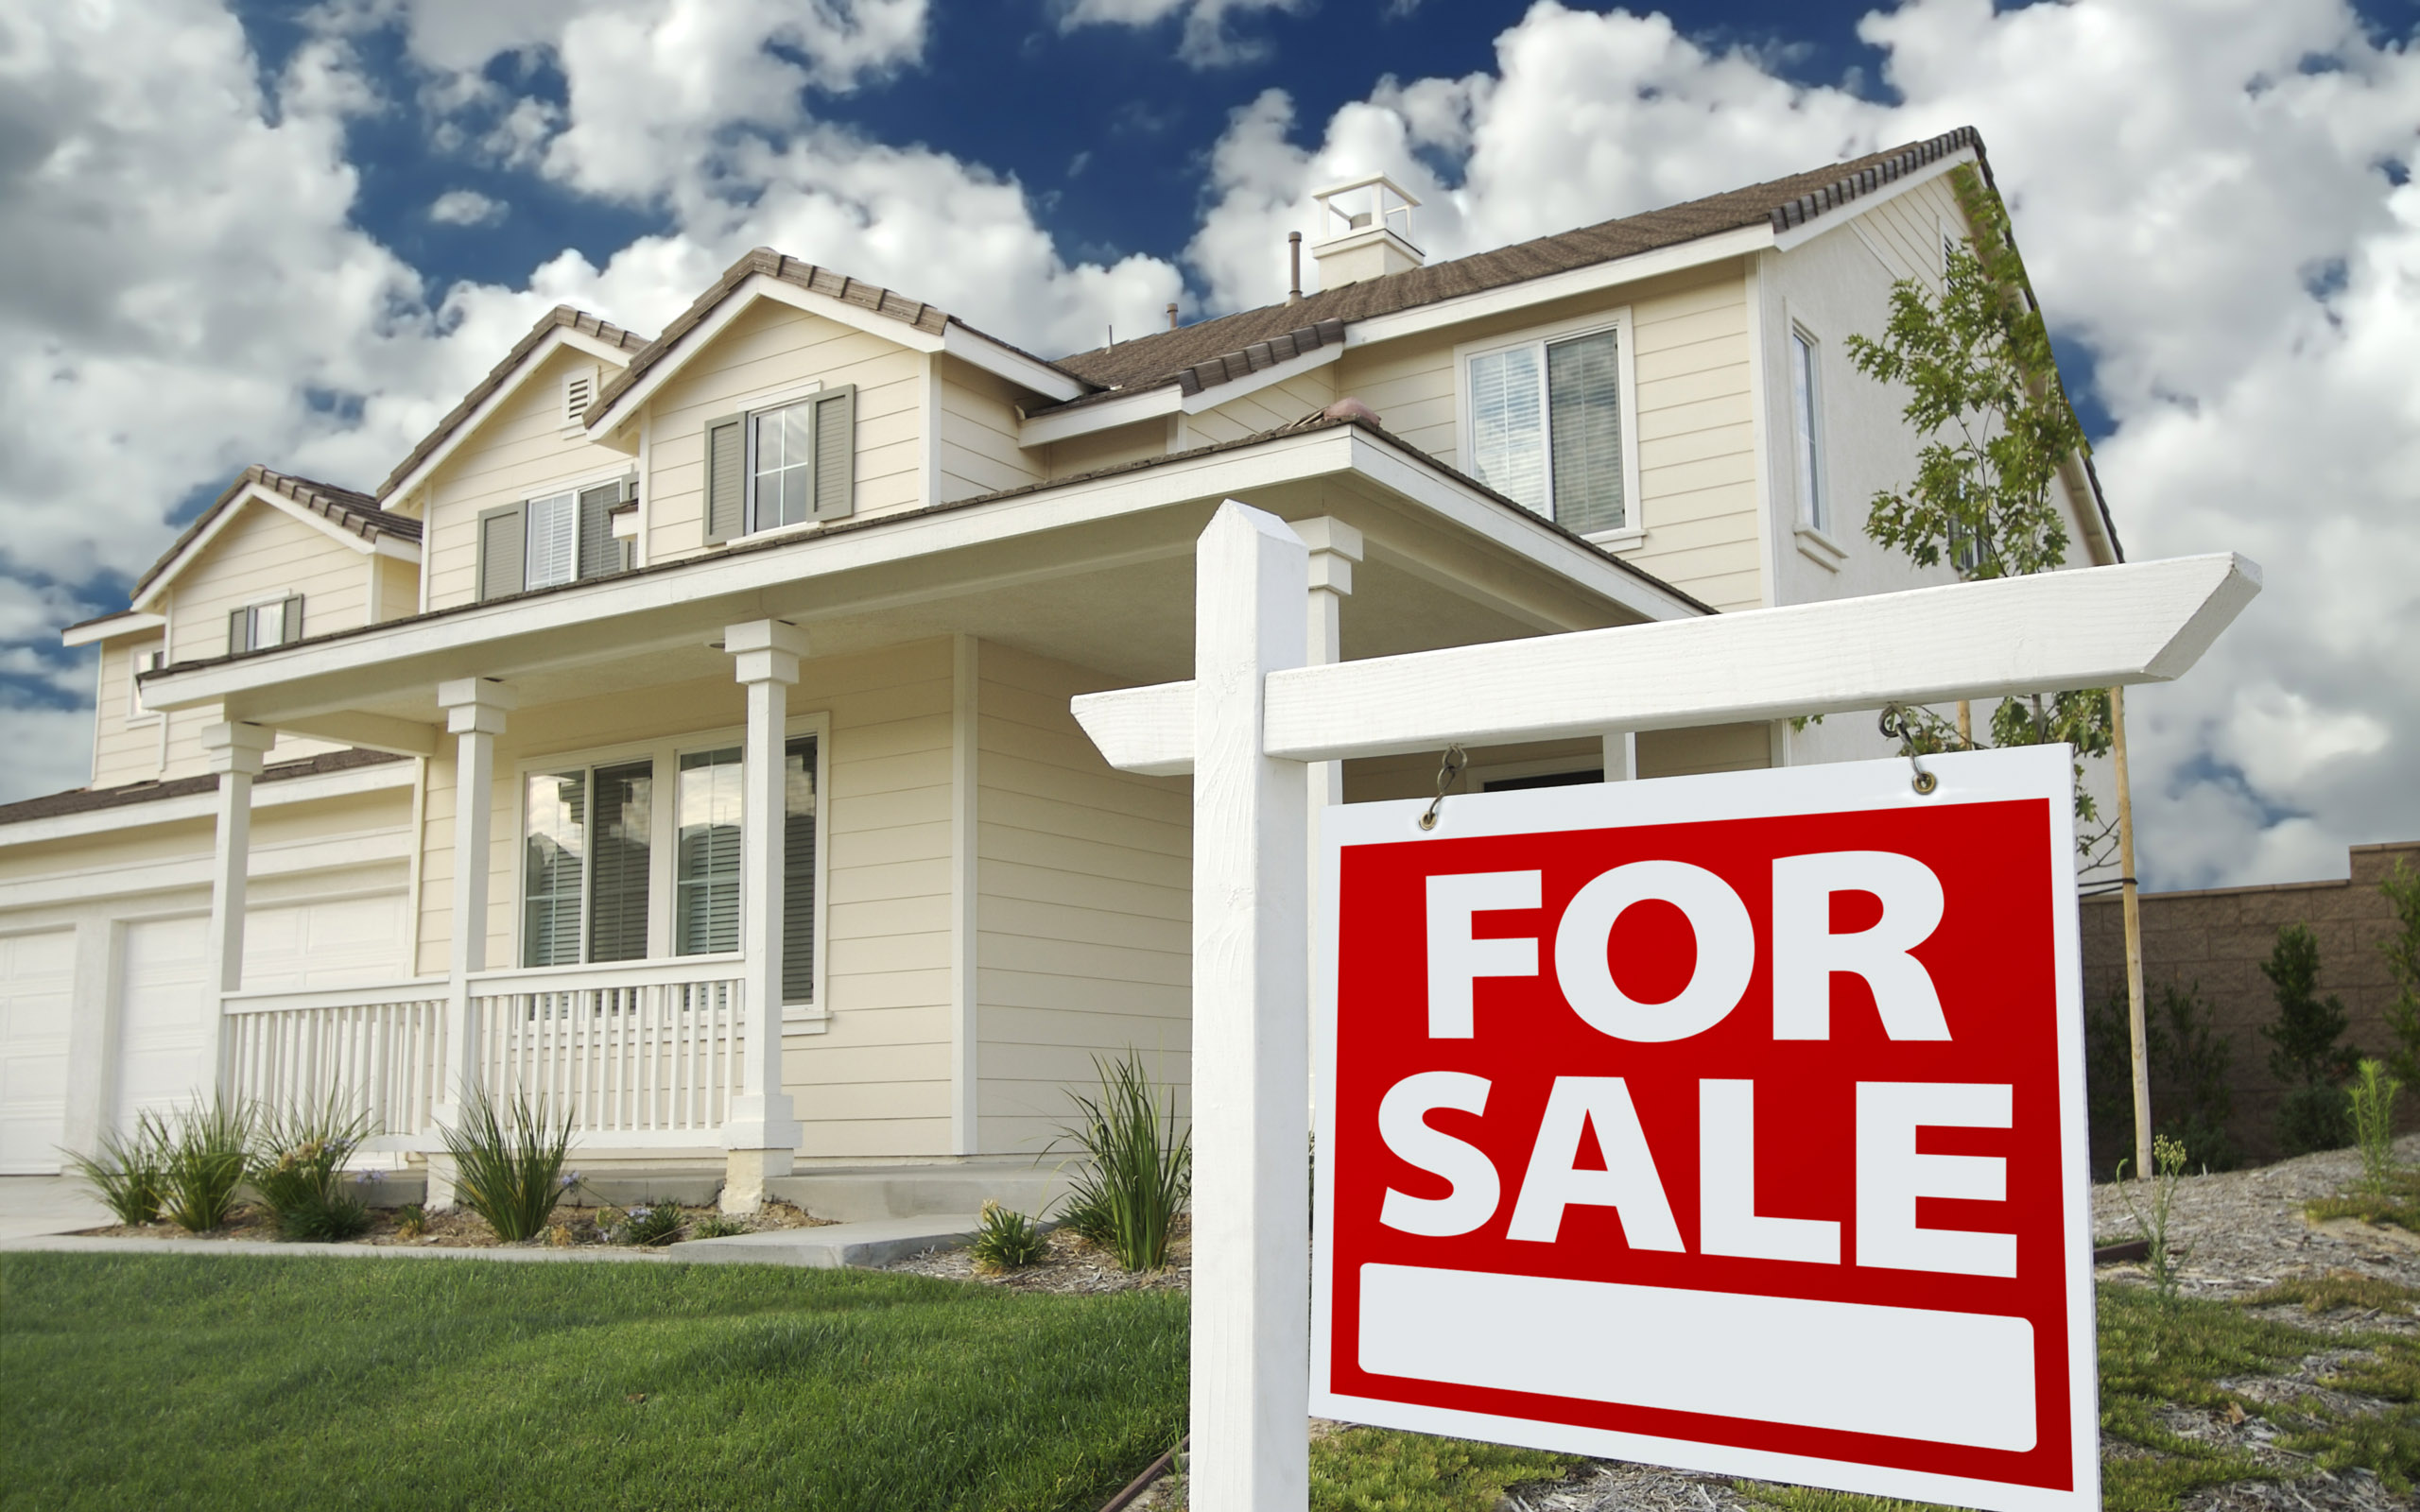


In this project, we are going to predict house sale prices in Ames, Iowa from 2006 to 2010 using basic kNN and Linear Regression. The purpose of this project is to covering some fundamental data preprocessing steps in a ML project as well as to compare the efficiency of different modles

We will follow the following pipeline:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

## Explore Dataset

We can read the description of different columns __[here](https://s3.amazonaws.com/dq-content/307/data_description.txt)__: 

In [2]:
houses = pd.read_csv('AmesHousing.tsv', delimiter='\t')
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

There are total of __2930__ entries and __82__ columns in the dataset. Some columns contain significant missing values which we will need to deal with later.

In [3]:
houses.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  
1        0       6    2010       WD           Normal     105000  
2    12500       6    2010       WD           Normal     172000  
3        0       4    2010       WD           Normal     244000  
4        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

### Ploting distribution of SalePrice (target)

Text(0.5, 1.0, 'Houses Prices Distribution in Ames, Iowa (2006-2010)')

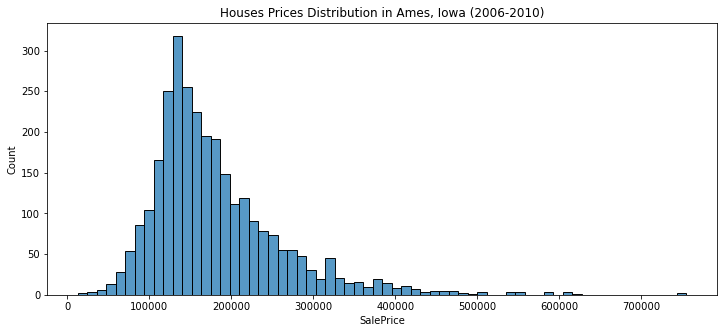

In [4]:
plt.figure(figsize=(12, 5))
ax = sns.histplot(houses['SalePrice'])
ax.set_title('Houses Prices Distribution in Ames, Iowa (2006-2010)')

### Some utility functions

In [5]:
def transform_features():
    return train

def select_features():
    return train[['Gr Liv Area', 'SalePrice']]

def train_and_test():
    train = data[:1460]
    test = data[1460:]
    numerical_train = train.select_dtypes(include=['float','int'])
    numerical_test = test.select_dtypes(include=['float','int'])
    
    features = numerical_train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    model = LinearRegression()
    model.fit(train[features], train[target])
    test_predictions = model.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test_predictions, test[target]))

## Feature Engineering
The __transform_features()__ focuses on handling numerical columns only. Before updating __transform_features()__ to capture the entire process of features engineering, let's explore each step manually and then we will update the whole function:
1. Drop any columns having > 25% missing values
2. Remove columns that leak data of final sale or seem to be unhelpful
3. Find numerical columns having less than 5% missing values and fill NaN with mode.
4. Add new features that better capture information



__1. Drop any columns having >25% missing values (for now)__

In [6]:
new_df = houses.copy()
new_df = new_df.dropna(axis=1, thresh = 0.75*len(houses))

__2. Remove columns that leak data of final sale or seem to be unhelpful__

- __PID__, __Order__ and __Garage Yr Blt__ columns are unhelpful since they do not provide any significant meaning.
- __Mo Sold__, __Sale Type__ and __Sale Condition__ columns leak information on final sale

In [7]:
cols_to_drop = ['Mo Sold', 'Garage Yr Blt', 'PID', 'Order', 'Sale Type', 'Sale Condition']
new_df = new_df.drop(cols_to_drop, axis=1)

__3a. Find numerical columns having less than 25% missing values and fill NaN with mean.__

In [8]:
numerical_missing_values = new_df.select_dtypes(include=['int64','float64']) #filter a df with numerical columns only
numerical_missing_values = numerical_missing_values.isnull().sum() # find total NAs in each column

#extract columnc having < 25% NA
missing_cols = numerical_missing_values[(numerical_missing_values > 0) & (numerical_missing_values/len(new_df) <= 0.25 )]
missing_cols = missing_cols.index
#fill these NA with mean
new_df[missing_cols] = new_df[missing_cols].fillna(new_df.mean())

__3b. Find object columns having less than 25% missing value and fill NaN with mode__

In [9]:
object_missing_values = new_df.select_dtypes(include=['object'])
object_missing_values = object_missing_values.isnull().sum()
missing_cols = object_missing_values[(object_missing_values > 0) & (object_missing_values/len(new_df) <= 0.25 )]
missing_cols = missing_cols.index
new_df[missing_cols] = new_df[missing_cols].fillna(new_df.mode().iloc[0])

__4. Add new features that better capture information__

Since the columns __Yr Sold__, __Year Built__, __Year Remod/Add__ are numerical but do not provide any significant meaning, we will calculate _Years Since Remod_ (Yr Sold - Year Remod/Add) and _Years Before Sale_ (Yr Sold - Year Built). Then we need to drop any rows that have negative difference as they are invalid

In [10]:
new_df['Years Since Remod'] = new_df['Yr Sold'] - new_df['Year Remod/Add']
new_df['Years Before Sale'] = new_df['Yr Sold'] - new_df['Year Built']

#Find negaive years_since_remod and years_before_sale
neg_year_since_remod = list(new_df[new_df['Years Since Remod'] < 0].index)
neg_year_before_sale = list(new_df[new_df['Years Before Sale'] < 0].index)
neg_year_diff = list(set(neg_year_since_remod) | set(neg_year_before_sale)) #Union of 2 lists

In [11]:
new_df = new_df.drop(neg_year_diff, axis =0)
new_df = new_df.drop(['Year Remod/Add', 'Year Built', 'Yr Sold'], axis=1)

__5. If we read the description of columns in the dataset in this link, we see that MS SubClass is a categorical type, not numerical. We need to convert this column to object first__

In [12]:
new_df['MS SubClass'] = new_df['MS SubClass'].astype('object')

Incorporate all steps above into **transform_features()**

In [13]:
def transform_features(df):
    new_df = df.copy()
    #Remove columns that has more than 25% missing values
    new_df = new_df.dropna(axis=1, thresh = 0.75*len(df))
    
    #Remove columns that leak data or seem to be unuseful
    cols_to_drop = ['Mo Sold', 'Garage Yr Blt', 'PID', 'Order', 'Sale Type', 'Sale Condition']
    new_df = new_df.drop(cols_to_drop, axis=1)
    
    #Find numerical columns having less than 25% missing values and fill them with most popular value
    numerical_missing_values = new_df.select_dtypes(include=['int64','float64'])
    numerical_missing_values = numerical_missing_values.isnull().sum()
    missing_cols = numerical_missing_values[(numerical_missing_values > 0) & (numerical_missing_values/len(new_df) <= 0.25 )]
    missing_cols = missing_cols.index
    new_df[missing_cols] = new_df[missing_cols].fillna(new_df.mean())
    
    #Find object columns having less than 25% missing value and fill NaN with mode
    object_missing_values = new_df.select_dtypes(include=['object'])
    object_missing_values = object_missing_values.isnull().sum()
    missing_cols = object_missing_values[(object_missing_values > 0) & (object_missing_values/len(new_df) <= 0.25 )]
    missing_cols = missing_cols.index
    new_df[missing_cols] = new_df[missing_cols].fillna(new_df.mode().iloc[0])
    
    #Add new features like years_until_remod and drop old features
    new_df['Years Since Remod'] = new_df['Yr Sold'] - new_df['Year Remod/Add']
    new_df['Years Before Sale'] = new_df['Yr Sold'] - new_df['Year Built']

    #Find negaive year since remod and years before sale
    neg_year_since_remod = list(new_df[new_df['Years Since Remod'] < 0].index)
    neg_year_before_sale = list(new_df[new_df['Years Before Sale'] < 0].index)
    neg_year_diff = list(set(neg_year_since_remod) | set (neg_year_before_sale)) #Union of 2 lists
    new_df = new_df.drop(neg_year_diff, axis =0)
    new_df = new_df.drop(['Year Remod/Add', 'Year Built', 'Yr Sold'], axis=1)
    
    #Convert MS SubClass to object
    new_df['MS SubClass'] = new_df['MS SubClass'].astype('object')
    return new_df

new_df = transform_features(houses)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2927 non-null   object 
 1   MS Zoning          2927 non-null   object 
 2   Lot Frontage       2927 non-null   float64
 3   Lot Area           2927 non-null   int64  
 4   Street             2927 non-null   object 
 5   Lot Shape          2927 non-null   object 
 6   Land Contour       2927 non-null   object 
 7   Utilities          2927 non-null   object 
 8   Lot Config         2927 non-null   object 
 9   Land Slope         2927 non-null   object 
 10  Neighborhood       2927 non-null   object 
 11  Condition 1        2927 non-null   object 
 12  Condition 2        2927 non-null   object 
 13  Bldg Type          2927 non-null   object 
 14  House Style        2927 non-null   object 
 15  Overall Qual       2927 non-null   int64  
 16  Overall Cond       2927 

## Feature Selection
After transforming our dataframe, we move on feature selection in which we will explore which features should be selected for the traning model. 

First we will explore the correlation of numerical columns with our target column __"Sale Price"__

In [14]:
numerical_cols = new_df.select_dtypes(include=['int64','float64']).columns
corrs = abs(new_df[numerical_cols].corr())
sorted_corrs = corrs['SalePrice'].sort_values(ascending=True)

For now let's select only columns that have > 0.5 correlation with Saleprice

In [15]:
strong_corrs = sorted_corrs[sorted_corrs > 0.5]
new_df_strong_corr = new_df[strong_corrs.index]
new_df_strong_corr

Mas Vnr Area  Years Since Remod  Full Bath  Years Before Sale  \
0            112.0                 50          1                 50   
1              0.0                 49          1                 49   
2            108.0                 52          1                 52   
3              0.0                 42          2                 42   
4              0.0                 12          2                 13   
...            ...                ...        ...                ...   
2925           0.0                 22          1                 22   
2926           0.0                 23          1                 23   
2927           0.0                 14          1                 14   
2928           0.0                 31          1                 32   
2929          94.0                 12          2                 13   

      1st Flr SF  Garage Area  Total Bsmt SF  Garage Cars  Gr Liv Area  \
0           1656        528.0         1080.0          2.0         1656   
1            896        730.0          882.0          1.0          896   
2           1329        312.0         1329.0          1.0         1329   
3           2110        522.0         2110.0          2.0         2110   
4            928        482.0          928.0          2.0         1629   
...          ...          ...            ...          ...          ...   
2925        1003        588.0         1003.0          2.0         1003   
2926         902        484.0          864.0          2.0          902   
2927         970          0.0          912.0          0.0          970   
2928        1389        418.0         1389.0          2.0         1389   
2929         996        650.0          996.0          3.0         2000   

      Overall Qual  SalePrice  
0                6     215000  
1                5     105000  
2                6     172000  
3                7     244000  
4                5     189900  
...            ...        ...  
2925             6     142500  
2926             5     131000  
2927             5     132000  
2928             5     170000  
2929             7     188000  

[2927 rows x 11 columns]

The next thing we need to look for is for potential collinearity between some of these feature columns. Collinearity is when 2 feature columns are highly correlated and stand the risk of duplicating information. We will generate a correlation heatmap using strong correlation columns

<AxesSubplot:>

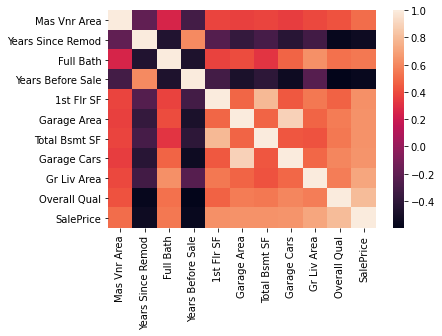

In [16]:
corrmat = new_df_strong_corr.corr()
sns.heatmap(corrmat)

From the heatmap, we see that 
- __Garage Cars__ and __Garage Area__ are strongly correlated
- __1st Flr SF__ and __Total Bsmt SF__ are quite correlated, but we will not drop neither for now

1. Hence we will drop the __Garage Cars__ columns and any columns having < 0.5 correlation with __SalePrice__.

In [17]:
new_df = new_df.drop(sorted_corrs[sorted_corrs < 0.5].index, axis =1)
new_df = new_df.drop('Garage Cars',axis=1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2927 non-null   object 
 1   MS Zoning          2927 non-null   object 
 2   Street             2927 non-null   object 
 3   Lot Shape          2927 non-null   object 
 4   Land Contour       2927 non-null   object 
 5   Utilities          2927 non-null   object 
 6   Lot Config         2927 non-null   object 
 7   Land Slope         2927 non-null   object 
 8   Neighborhood       2927 non-null   object 
 9   Condition 1        2927 non-null   object 
 10  Condition 2        2927 non-null   object 
 11  Bldg Type          2927 non-null   object 
 12  House Style        2927 non-null   object 
 13  Overall Qual       2927 non-null   int64  
 14  Roof Style         2927 non-null   object 
 15  Roof Matl          2927 non-null   object 
 16  Exterior 1st       2927 

2. Handle categorical columns: find the unique counts of each categorical column and drop columns that have > 10 unique values

In [18]:
uniqueness_counts = new_df.select_dtypes(include='object').apply(lambda x: len(x.value_counts())).sort_values()
drop_nonuniq_counts = uniqueness_counts[uniqueness_counts > 10].index
new_df = new_df.drop(drop_nonuniq_counts, axis=1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS Zoning          2927 non-null   object 
 1   Street             2927 non-null   object 
 2   Lot Shape          2927 non-null   object 
 3   Land Contour       2927 non-null   object 
 4   Utilities          2927 non-null   object 
 5   Lot Config         2927 non-null   object 
 6   Land Slope         2927 non-null   object 
 7   Condition 1        2927 non-null   object 
 8   Condition 2        2927 non-null   object 
 9   Bldg Type          2927 non-null   object 
 10  House Style        2927 non-null   object 
 11  Overall Qual       2927 non-null   int64  
 12  Roof Style         2927 non-null   object 
 13  Roof Matl          2927 non-null   object 
 14  Mas Vnr Type       2927 non-null   object 
 15  Mas Vnr Area       2927 non-null   float64
 16  Exter Qual         2927 

3. Drop low variance column (do later)

 i. For numerical columns, we first need to standardize each column then calculate the variance
 

In [19]:
#Numerical Column, standardize and calculate variance
numerical_cols = new_df.select_dtypes(include=['float64','int64']).columns
numerical_cols = numerical_cols.drop('SalePrice')

unit_numerical_df = (new_df[numerical_cols] - new_df[numerical_cols].min())/(new_df[numerical_cols].max() - new_df[numerical_cols].min())
unit_numerical_df.var()

Overall Qual         0.024461
Mas Vnr Area         0.012218
Total Bsmt SF        0.005012
1st Flr SF           0.007742
Gr Liv Area          0.008794
Full Bath            0.019077
Garage Area          0.020793
Years Since Remod    0.120806
Years Before Sale    0.049585
dtype: float64

We will randomly pick a threshold of 0.006

In [20]:
drop_low_var_cols = pd.Series(unit_numerical_df.var())
new_df_copy = new_df.drop(drop_low_var_cols[drop_low_var_cols < 0.006].index, axis = 1, errors='ignore')

ii. Object column (Category).

In [21]:
object_cols = new_df.select_dtypes(include=['object']).columns
low_var_obj_cols = []
for col in object_cols:
    unique_counts = new_df[col].value_counts()/len(new_df)
    if (unique_counts > 0.9).sum():
        low_var_obj_cols.append(col)

new_df_copy = new_df_copy.drop(low_var_obj_cols, axis=1, errors='ignore')
print("Number of object columns dropped:", len(low_var_obj_cols))
#print(new_df.info())

Number of object columns dropped: 13


4. Convert object column to category and create dummy columns 

In [22]:
object_cols = new_df_copy.select_dtypes(include='object').columns
for col in object_cols:
    new_df_copy[col] = new_df_copy[col].astype('category')
new_df_copy = pd.concat([new_df_copy, pd.get_dummies(new_df_copy.select_dtypes(include='category'))], axis=1)
new_df_copy = new_df_copy.drop(object_cols, axis=1)
new_df_copy.head(10)


Overall Qual  Mas Vnr Area  1st Flr SF  Gr Liv Area  Full Bath  \
0             6         112.0        1656         1656          1   
1             5           0.0         896          896          1   
2             6         108.0        1329         1329          1   
3             7           0.0        2110         2110          2   
4             5           0.0         928         1629          2   
5             6          20.0         926         1604          2   
6             8           0.0        1338         1338          2   
7             8           0.0        1280         1280          2   
8             8           0.0        1616         1616          2   
9             7           0.0        1028         1804          2   

   Garage Area  SalePrice  Years Since Remod  Years Before Sale  \
0        528.0     215000                 50                 50   
1        730.0     105000                 49                 49   
2        312.0     172000                 52                 52   
3        522.0     244000                 42                 42   
4        482.0     189900                 12                 13   
5        470.0     195500                 12                 12   
6        582.0     213500                  9                  9   
7        506.0     191500                 18                 18   
8        608.0     236500                 14                 15   
9        442.0     189000                 11                 11   

   MS Zoning_A (agr)  ...  Kitchen Qual_TA  Garage Type_2Types  \
0                  0  ...                1                   0   
1                  0  ...                1                   0   
2                  0  ...                0                   0   
3                  0  ...                0                   0   
4                  0  ...                1                   0   
5                  0  ...                0                   0   
6                  0  ...                0                   0   
7                  0  ...                0                   0   
8                  0  ...                0                   0   
9                  0  ...                0                   0   

   Garage Type_Attchd  Garage Type_Basment  Garage Type_BuiltIn  \
0                   1                    0                    0   
1                   1                    0                    0   
2                   1                    0                    0   
3                   1                    0                    0   
4                   1                    0                    0   
5                   1                    0                    0   
6                   1                    0                    0   
7                   1                    0                    0   
8                   1                    0                    0   
9                   1                    0                    0   

   Garage Type_CarPort  Garage Type_Detchd  Garage Finish_Fin  \
0                    0                   0                  1   
1                    0                   0                  0   
2                    0                   0                  0   
3                    0                   0                  1   
4                    0                   0                  1   
5                    0                   0                  1   
6                    0                   0                  1   
7                    0                   0                  0   
8                    0                   0                  0   
9                    0                   0                  1   

   Garage Finish_RFn  Garage Finish_Unf  
0                  0                  0  
1                  0                  1  
2                  0                  1  
3                  0                  0  
4                  0                  0  
5                  0                  0  
6                  0          

Update __select_features()__ 

In [23]:
def select_features(df, corr_threshold = 0.5, unique_threshold = 10):
    new_df = df.copy()
    
    #Select only columns having high correlation with SalePrice
    numerical_cols = new_df.select_dtypes(include=['int64','float64']).columns
    corrs = abs(new_df[numerical_cols].corr())
    sorted_corrs = corrs['SalePrice'].sort_values(ascending=True)
    new_df = new_df.drop(sorted_corrs[sorted_corrs < corr_threshold].index, axis =1)
    new_df = new_df.drop('Garage Cars',axis=1, errors='ignore')
    
    #Drop any object columns that have more then corr_threshold unique values
    uniqueness_counts = new_df.select_dtypes(include='object').apply(lambda x: len(x.value_counts())).sort_values()
    drop_nonuniq_counts = uniqueness_counts[uniqueness_counts > unique_threshold].index
    new_df = new_df.drop(drop_nonuniq_counts, axis=1)
    
    #Drop any numerical columns that have low variance
    numerical_cols = new_df.select_dtypes(include=['float64','int64']).columns
    numerical_cols = numerical_cols.drop('SalePrice')
    #standardize
    unit_numerical_df = (new_df[numerical_cols] - new_df[numerical_cols].min())/(new_df[numerical_cols].max() - new_df[numerical_cols].min())
    drop_low_var_cols = pd.Series(unit_numerical_df.var())
    new_df = new_df.drop(drop_low_var_cols[drop_low_var_cols < 0.006].index, axis = 1, errors='ignore')
    
    #Drop any object columns that have low variance if > 90% of values in the column belong to a specific category 
    object_cols = new_df.select_dtypes(include=['object']).columns
    low_var_obj_cols = []
    for col in object_cols:
        unique_counts = new_df[col].value_counts()/len(new_df)
        if (unique_counts > 0.9).sum():
            low_var_obj_cols.append(col)
    new_df = new_df.drop(low_var_obj_cols, axis=1, errors='ignore')
    
    #Convert object columns to category
    object_cols = new_df.select_dtypes(include=['object']).columns
    for col in object_cols:
        new_df[col] = new_df[col].astype('category')
    
    #Get dummies columns from category columns and drop all category columns
    new_df = pd.concat([new_df, pd.get_dummies(new_df.select_dtypes(include='category'))], axis=1)
    new_df = new_df.drop(object_cols, axis=1)
    return new_df
    
final_df = select_features(new_df)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Columns: 117 entries, Overall Qual to Garage Finish_Unf
dtypes: float64(2), int64(7), uint8(108)
memory usage: 537.4 KB


## Train and Test 

Final step is training and testing. We will update the __train_and_test()__ function with optional parameter __k__ whose default value is 0 that controls the type of cross validation. For example,:
- k = 0, perform holdout validation:
 - Select the first 1460 rows and assign to train.
 - Select the remaining rows and assign to test.
 - Train on train and test on test.
 - Compute the RMSE and return.


- k = 1, perform simple cross validation
 - Shuffle the ordering of the rows in the data frame.
 - Select the first 1460 rows and assign to fold_one.
 - Select the remaining rows and assign to fold_two.
 - Train on fold_one and test on fold_two.
 - Train on fold_two and test on fold_one.
 - Compute the average RMSE and return.
 
 
- k > 1, implement k-fold cross validation using k folds:
 - Perform k-fold cross validation using KFold class and cross_val_score
 - Calculate the average RMSE value and return this value.

First we will train the model using numerical columns only, i.e omit out category columns.

In [24]:
def train_and_test(data, k = 0):
    train = data.iloc[:1460]
    test = data.iloc[1460:]
    train = train.select_dtypes(include=['float64','int64'])
    test = test.select_dtypes(include=['float64','int64'])
    
    features = train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    model = LinearRegression()
    model.fit(train[features], train[target])
    test_predictions = model.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test_predictions, test[target])) 
    return rmse

rmse = train_and_test(final_df)
print(rmse)

36615.91192199894


Now let's include all the columns and see if the model performance gets better

In [25]:
def train_and_test(data, k = 0):
    train = data.iloc[:1460]
    test = data.iloc[1460:]
    features = train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    model = LinearRegression()
    model.fit(train[features], train[target])
    test_predictions = model.predict(test[features])
    rmse = np.sqrt(mean_squared_error(test_predictions, test[target])) 
    return rmse

rmse = train_and_test(final_df)
print(rmse)

30660.772664966207


The RMSE decreases by 13% by including all columns which is a good sign. Next we will implement k-fold cross validation. We will also update the __train_and_test()__ function to handlr all cases including k=0,1 and k > 1.

Moreover, achieving lowest RMSE is not the ultimate goal. The average of RMSEs definitely decreases as we increase the number of folds, k. However, standard deviation increases as k increases. We need to balance this tradeoff. We will calculate the STD for each k plot both mean RMSEs and STD for each k. 


### K-Fold cross validation

In [26]:
from sklearn.model_selection import cross_val_score, KFold
def train_and_test(data, k=0):
    features = data.columns.drop('SalePrice')
    target = 'SalePrice'
#    data[features] = (data[features] - data[features].min())/(data[features].max() - data[features].min())
    model = LinearRegression()
    
    if k == 0:
        train = data.iloc[:1460]
        test  = data.iloc[1460:]
        model.fit(train[features], train[target])
        test_predictions = model.predict(test[features]) 
        avg_rmse = np.sqrt(mean_squared_error(test_predictions, test[target]))
        std = 0.0
    
    elif k == 1:
        shuffled_index = np.random.permutation(data.index)
        data_shuffled = data.reindex(shuffled_index)
        fold_one = data_shuffled.iloc[:1460]
        fold_two = data_shuffled.iloc[1460:]
        
        #1st half
        model.fit(fold_one[features], fold_one[target])
        test_predictions = model.predict(fold_two[features])
        iteration_one_rmse = np.sqrt(mean_squared_error(test_predictions, fold_two[target]))   
        
        #2nd half
        model.fit(fold_two[features], fold_two[target])
        test_predictions = model.predict(fold_one[features])
        iteration_two_rmse = np.sqrt(mean_squared_error(test_predictions, fold_one[target]))
        
        avg_rmse = np.mean([iteration_one_rmse, iteration_two_rmse])
        std = np.std([iteration_one_rmse, iteration_two_rmse])
    
    else:   
        kf = KFold(k, shuffle=True, random_state=1)
        mses = cross_val_score(model, data[features], data[target], scoring='neg_mean_squared_error', cv=kf)
        rmses = np.sqrt(abs(mses))
        avg_rmse = np.mean(rmses)
        std = np.std(rmses)
        
    return avg_rmse,std

rmse, std = train_and_test(final_df,0)
print("RMSE for 0 fold: ",rmse)
print("STD for 0 fold: ", std)


RMSE for 0 fold:  30660.772664966207
STD for 0 fold:  0.0


#### Plot the RMSE vs Number of K Folds

Text(0.5, 0, 'K')

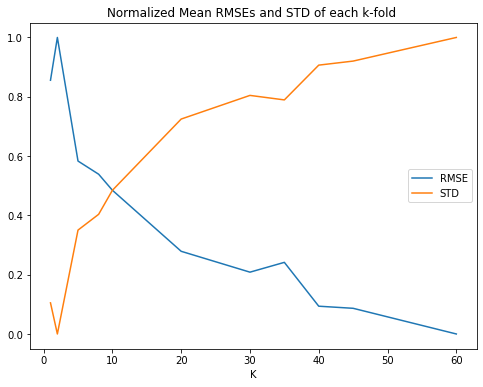

In [27]:
k_fold = [1, 2, 5, 8, 10, 20, 30, 35, 40, 45, 60]
rmses = []
stds = []
for k in k_fold:
    rmse, std = train_and_test(final_df, k)
    rmses.append(rmse)
    stds.append(std)

#Normalize RMSEs and STDs to get them on scale
y_rmse = (rmses - min(rmses)) / (max(rmses) - min(rmses))
y_std = (stds - min(stds)) / (max(stds) - min(stds))
plt.figure(figsize=(8,6))
plt.plot(k_fold, y_rmse)
plt.plot(k_fold, y_std)
plt.legend(["RMSE", "STD"])
plt.title("Normalized Mean RMSEs and STD of each k-fold ")
plt.xlabel('K')


We will pick the optimal point which is the intersection of the 2 curve. Hence k= 10 is our optimal choice for K-fold validation

In [33]:
print("k = 10, RMSE= {}, STD= {}".format(rmses[k_fold.index(10)], stds[k_fold.index(10)]))


k = 10, RMSE= 27789.307377284866, STD= 5512.664056420494


## Conclusion

In a Machine Learning project, __feature engineering__ and __feature selections__ are two of most important steps that needs to be done before designing any model. 

- __Feature engineering__, in other words data preprocessing, includes but not limit to handling missing values, data type conversion, dropping irrelevant features, adding new features.

- __Feature selections__: determines which columns (features) to include your training model. In case of Linear Regression, it's advisable to calculate correlations between each feature and the target to determine the degree of linearity of each feature vs target; and to calcuate cross-correlations between features to determine co-linearity. Colinear features represent redundant information. Dropping more unneccessary features make our model traing faster.

We found k= 10 is the optimal value for K-Fold cross validation with __RMSE__ = $27789 with __STD__ = 5512